# Compute scattering coefficients

Edited by Louise, 10-07-2023

In this Notebook, we show how scattering coefficients are computed. The code presented here is implemented in `Scattering_lib.py` and you can compute the coefficients by calling the function `scat_cov_dir()`. Here I do it step by step to explain the algorithm. 

In [1]:
import s2wav.utils.shapes
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
#import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload
import jax.lax as lax

#from PIL import Image
#from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
#import s2wav

import scatcovjax.plotting as plot

In [2]:
plot.notebook_plot_format()

# 1 - Parameters
We define the following parameters:
- sampling: for now the code works in Max-Wiaux (MW) sampling, no Healpix. Maybe it could work in Healpix but not sure and because the harmonic transforms are exact in MW sampling, we decided to start with a MW implementation.
- multiresolution: should always be True so that the code goes faster
- reality: put True if the map is real so we can store only alm for $m>0$
- $L=4, 8, 16, 32...$ is the resolution: the pixel number will be $N_\theta \times N_\varphi = L \times (2L-1)$
- $N=1, 2, 3...$ defines the number of orientations which is $2N-1$. If $N=1$ we get axisym wavelets.
- $J_{min}$ is the index of the first wavelet you want to consider (largest scale).
- $Nside$, is None in case of MW sampling

From these parameters, we compute:
- $J_{max}$ is the maximal $j$ index that will be considered (smallest scale)
- $J = J_{max} - J_{min} + 1 $ is the number of scales.


In [3]:
### Input parameters
sampling = "mw"
multiresolution = True
reality = True
L = 64
N = 1
J_min = 2
nside = None

### This input parameters impose:
J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J_max=}, {J=}')

J_max=6, J=5


# 2 - Make a data map

We build a MW map to compute the scattering coefficients on. It can be random noise, LSS map, a planet image as Venus. Choose the example you prefer.

The map is called $I$ and we also compute $I_{\ell m}$, the Spherical Harmonic Transform (SHT) of the map.

The shape of the map $I$ is $[L, 2L-1]$. 

The shape of $I_{\ell m}$ is $[L, L]$ if reality=True and $[L, 2L-1]$ if reality=False.

In [4]:
# Random noise
# np.random.seed(2)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
# Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)

### Large scale structure (LSS) map
I, Ilm = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
print('Target = LSS map')
print(I.shape, Ilm.shape)

### Planet image
# I, Ilm = sphlib.make_planet(L, 'venus', normalize=True, reality=reality)
# print('Target = Planet map', '(Ntheta, Nphi)=', I.shape)
# print('Ilm', Ilm.shape)


Target = LSS map
(64, 127) (64, 64)


### Plot the map 

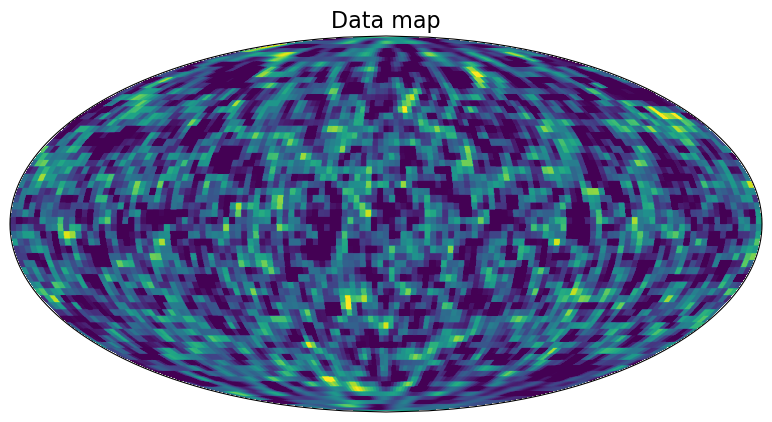

In [5]:
plot.plot_map_MW_Mollweide(I, figsize=(8, 6), vmin=-1, vmax=3, title='Data map')

### Plot $I_{\ell m}$

In case of real map, this plot function creates the $m<0$. We will do the same when computing scattering coefficients.

Note that on this plot, we display the $\ell$ and $m$ values but:
- $\ell$ goes from $0$ to $L-1$ so the indices in the array match the $\ell$ values
- $m$ goes from $-(L-1)$ to $L-1$ so the $m$ indices go from 0 to $2L-2$.
If you want the term corresponding to $(\ell, m)=(0, 0)$ you need to take the indices $(0, L-1)$.

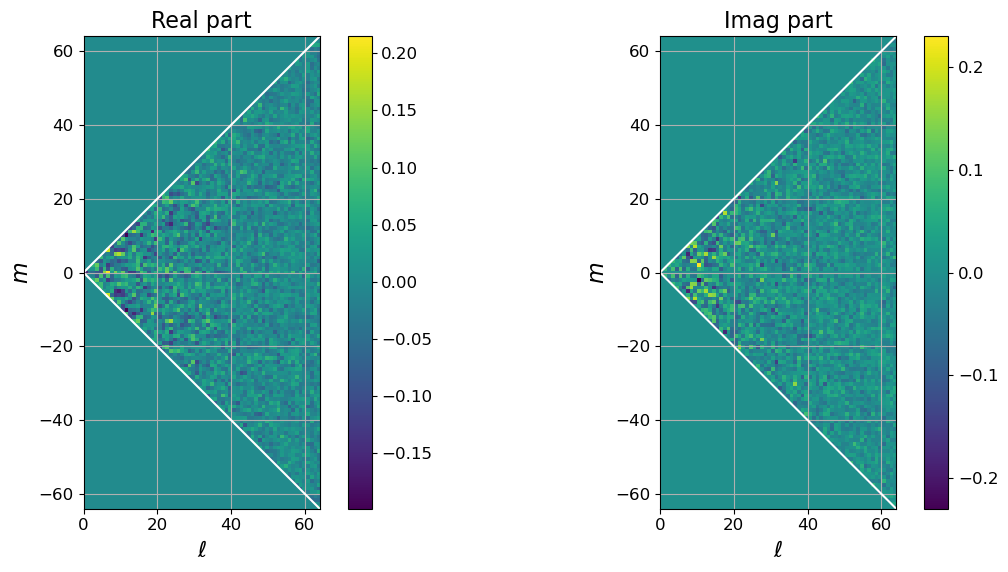

In [6]:
fig = plot.plot_alm(Ilm, reality=reality)



# 3 - Build the wavelet set

We get $J$ filters, each one corresponding to a $j$ scale from $J_{min}$ to $J_{max}$. 
Remember that when $j$ increases, the physical scale decreases. This is the opposite in pyWPH, pyWST... 

Filters are defined in harmonic space.

Note that whatever is $J_{min}$, filters start at $j=0$. It has $J_{max} + 1$ terms, not $J$ so that the shape is  $[J_{max}+1, L, 2L-1]$.

Filters are complex number but depending if $N$ is odd or even, either the real or the imaginary part is zero.

In [7]:
filters_and_scaling = filters_directional_vectorised(L, N, J_min)  # ([J, L, 2L-1], [L])

# This function returns a tuple with the wavelets and the scaling function so we take only the wavelets:
filters = filters_and_scaling[0]

# Check the shape
print(J, J_max, filters.shape)

5 6 (7, 64, 127)


### Plot the filters

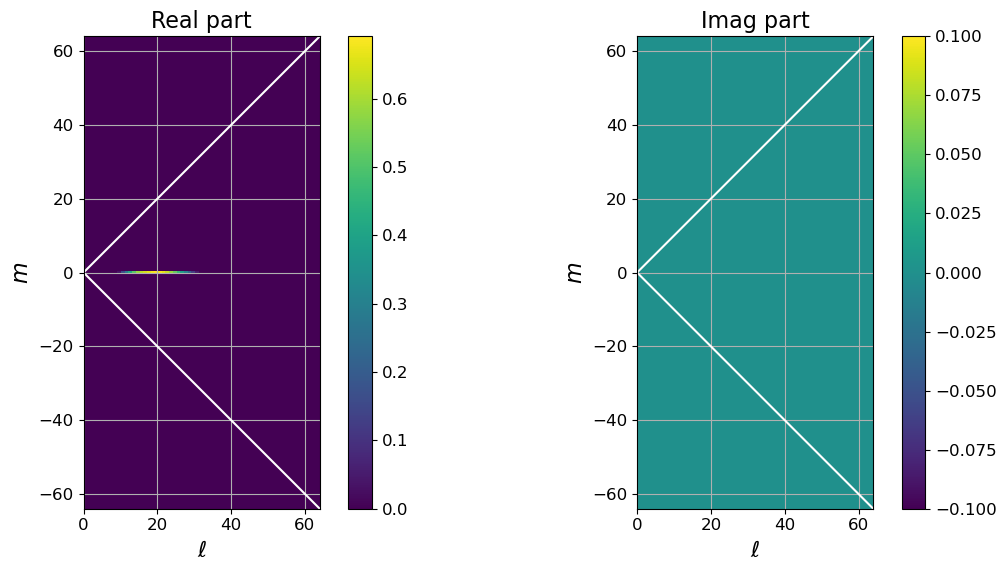

In [8]:
### Choose a specific scale j
j = 4
fig = plot.plot_alm(filters[j, :, :])

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='Filters $\\Psi^j_{\\ell 0}$'>)

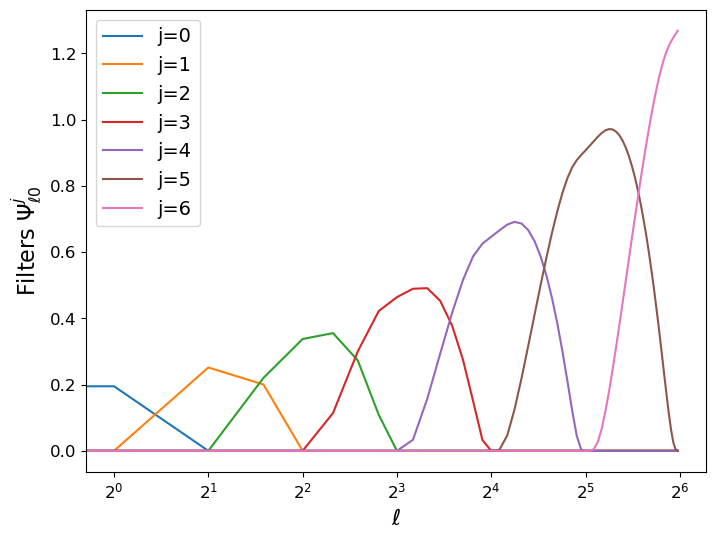

In [9]:
### Plot all scales with a cut at a given m
plot.plot_filters(filters_and_scaling, real=True, m=L-1)


# 4 - Compute the scattering coefficients

## 1) Get all the coefficients in one step

Here we call the function that computes all the coefficients. You have to pass it the data in harmonic space $I_{\ell m}$ and the wavelets $filters[0]$

In [10]:
reload(scatlib)
 
mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(Ilm, 
                                                    L, 
                                                    N, 
                                                    J_min, 
                                                    sampling, 
                                                    nside, 
                                                    reality, 
                                                    multiresolution, 
                                                    filters=filters, 
                                                    normalisation=None, 
                                                    for_synthesis=False)


 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=64


In [11]:
print(C01, len(C01))

[Array([[[-0.00145925]],

       [[-0.00109151]],

       [[ 0.00045574]],

       [[ 0.00077139]]], dtype=float64), Array([[[-0.00487589]],

       [[-0.00038859]],

       [[ 0.00074214]]], dtype=float64), Array([[[-0.00089273]],

       [[ 0.00163064]]], dtype=float64), Array([[[-0.003628]]], dtype=float64)] 4


## 2) Compute the coefficients step by step

This is to check the algorithm.

### Quadrature weights
We first compute the quadrature weights to make spherical integral in pixel space. This is a list of $J$ elements. Each element has a $L_j$ shape (multiresolution).

In [12]:
quads = []
for j in range(J_min, J_max + 1):
    # Compute Lj: the resolution L adapted to the j scale
    Lj = s2wav.utils.shapes.wav_j_bandlimit(L, j, 2.0, multiresolution)
    # Compute the quad at this j scale
    quads.append(s2fft.quadrature_jax.quad_weights(Lj, sampling, nside))  # [J][Lj]
    print(Lj, quads[j-J_min].shape)

print(J, len(quads))

8 (8,)
16 (16,)
32 (32,)
64 (64,)
64 (64,)
5 5


### Part of the Wigner transform
We compute a part of the Wigner transform which needs to be computed only once because it does not depend on the data. This is why it can be passed to the function as an argument (same for the quads). 

Je ne sais pas exactement quelle partie du calcul c'est.

In [13]:
precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)  # [J][J+1][?]


In [14]:
## ?? On obtient une liste de listes qui contient des arrays
## Je ne comprends pas bien la shape
print(len(precomps), len(precomps[3]), precomps[0][3].shape)

5 5 (1, 9, 6)


### Make the missing $I_{\ell m}$ in case of a real map

If the map is real (only m>0 stored), we create the (m<0) part.

In [15]:
if reality:
    Ilm = sphlib.make_flm_full(Ilm, L)  # [L, 2L-1]
    print(Ilm.shape)   

(64, 127)


### Mean of the map

The mean is computed from the $I_{\ell m}$ at $(\ell, m)=(0, 0)$:

$$\langle I\rangle_{pix} = \frac{I_{00}}{2\sqrt{\pi}} $$ 

In [16]:
# The m=0 term is at index L-1
mean = jnp.abs(Ilm[0, L - 1] / (2 * jnp.sqrt(jnp.pi)))

### Variance of the map

We compute the variance of the map in harmonic space using Parseval theorem:

$$Var = \frac{1}{4\pi} \sum_{(\ell, m) \neq (0, 0)} |I_{\ell m}|^2 $$

In [17]:
# |Ilm|^2 = Ilm x Ilm*
Ilm_square = Ilm * jnp.conj(Ilm)

# Variance: Sum all except the (l=0, m=0) term
var = (jnp.sum(Ilm_square) - Ilm_square[0, L - 1]) / (4 * np.pi)

### First wavelet transform of the map $I$

We convolve the map $I$ by the wavelet set for each scale $j_2$.
$$ W^{j_2} = I * \Psi^{j_2} $$

$W$ is defined in pixel space. It has a $[N_\theta, N_\varphi]$ shape plus one dimension for the $J$ scales and one for the $(2N-1)$ orientations. It is a list of $J$ arrays. Because of subsampling,  $ N_\theta$ and $N_\varphi$ vary for each scale $j_2$.  

In [18]:
W = s2wav.flm_to_analysis(
        Ilm,
        L,
        N,
        J_min,
        sampling=sampling,
        nside=nside,
        reality=reality,
        multiresolution=multiresolution,
        filters=filters,
        precomps=None
    )  # [J2][Norient2, Nthetaj2, Nphij2]=[J][2N-1, Lj, 2Lj-1]

In [19]:
# Check the shape
print(len(W), W[0].shape, W[-1].shape)

5 (1, 8, 15) (1, 64, 127)


### Loop on $j_2$ scales to compute $N^{j_1j_2}$

We define the modulus $M^{j_2} = |W^{j_2}|$ in pixel space and its SHT transform $M^{j_2}_{\ell m}$. In the loop on $j_2$, we start by computing the modulus for all orientations. 

Then, from the $M^{j_2}_{\ell m}$, we compute: $$S^{j_2}_1 = < M^{j_2} >_{pix} = \frac{M^{j_2}_{00}}{2\sqrt{\pi}}$$

And we also compute $P_{00}$ by doing the average in pixel space: 
$$P^{j_2}_{00} = \frac{1}{4\pi} \sum_{\theta, \varphi} |W^{j_2}|^2 w^{j_2} $$
where $w^{j_2}$ are the quadrature weights.

The wavelet transform of $M$ is called $N^{j_1j_2} = M^{j_2} * \Psi^{j_1}$. We need to compute it to get $C_{01}$ and $C_{11}$. We have:

$$C^{j_1j_2}_{01} = \langle W^{j_1} (M^{j_2} * \Psi^{j_1})^*\rangle$$

so we need to have $j_1 < j_2$ so that the second convolution is always done at a larger scale. Thus, we have 
$$J_{min} \leq j_1 \leq J_{max}-1 $$
$$j_1 + 1 \leq j_2 \leq J_{max}$$



 j2=2 Lj2=8

 j2=3 Lj2=16
3

 j2=4 Lj2=32
4

 j2=5 Lj2=64
5

 j2=6 Lj2=64
5


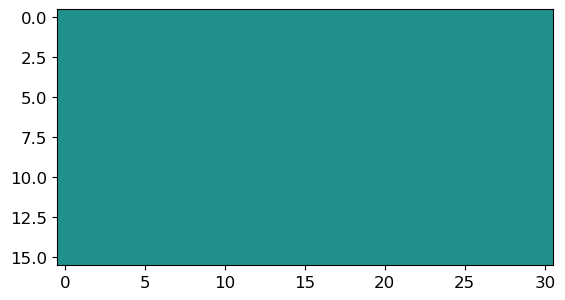

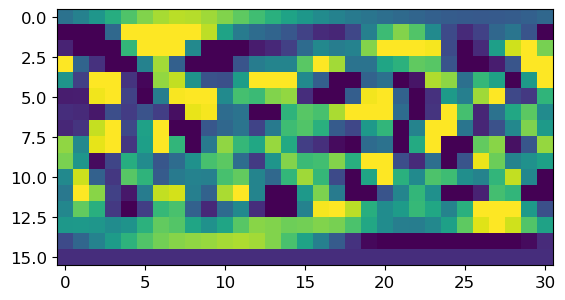

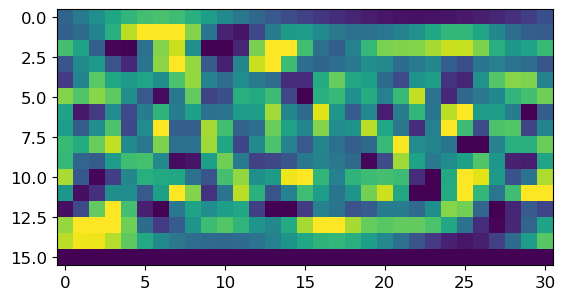

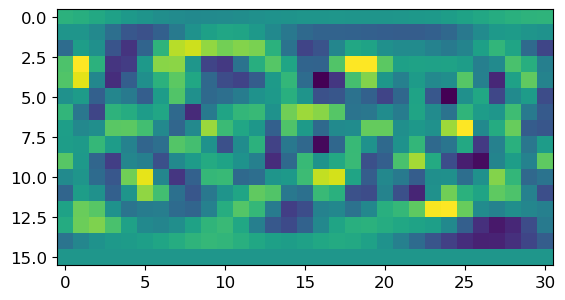

In [20]:
Njjprime = []
S1 = []
P00 = []
for j2 in range(J_min, J_max + 1):
    ### Subsampling: the resolution in the plane (l, m) is adapted at each scale j2
    Lj2 = s2wav.utils.shapes.wav_j_bandlimit(L, j2, 2.0, multiresolution)  # Band limit at resolution j2
    print(f'\n {j2=} {Lj2=}')

    def modulus_step_for_j(n, args):
        """
        Compute M_lm = |W|_lm for one orientation.
        This function is re-defined at each step j2.
        """
        M_lm = args
        M_lm = M_lm.at[n].add(
            s2fft.forward_jax(
                jnp.abs(W[j2 - J_min][n]),
                Lj2,
                0,
                sampling=sampling,
                nside=nside,
                reality=reality,
            )
        )
        return M_lm  # [Lj2, 2Lj2-1]

    ### Compute M_lm for all orientations
    # Initialization of the array
    M_lm_j2 = jnp.zeros((2 * N - 1, Lj2, 2 * Lj2 - 1), dtype=jnp.complex128)  # [Norient2, Lj2, 2Lj2-1]
    # Loop on orientations
    M_lm_j2 = lax.fori_loop(0, 2 * N - 1, modulus_step_for_j, M_lm_j2)  # [Norient2, Lj2, 2Lj2-1]

    ### Compute S1_j2 = < M >_j2
    # Take the value at (l=0, m=0) which corresponds to indices (0, Lj2-1)
    val = M_lm_j2[:, 0, Lj2 - 1] / (2 * jnp.sqrt(jnp.pi))  # [Norient2]
    # Discard the imaginary part
    val = jnp.real(val)
    S1.append(val)  # [J2][Norient2]
    
    ### Compute P00_j2 = < |W_j2(theta, phi)|^2 >_tp
    # Average over theta phi (Parseval)
    val = jnp.sum((jnp.abs(W[j2 - J_min]) ** 2)
                   * quads[j2-J_min][None, :, None], axis=(-1, -2)) / (4 * np.pi)  # [Norient2]
    P00.append(val)  # [J2][Norient2]
    
    ### Compute Njjprime
    # The iteration at j2=Jmin was only needed for S1 and P00 so we do not do the Njjprime computation when j2=Jmin.
    if j2 != J_min:
        # Filters: We must keep all scales
        # the selection from J_min to J_max=j2-1 is done in the function flm_to_analysis()
        filters_j2 = filters[:, :Lj2, L - Lj2: L - 1 + Lj2]
        
        Njjprime_for_j2 = []
        # Loop on orientations
        for n in range(2*N-1):
            # Wavelet transform of M: Nj1j2 = M_j2 * Psi_j1
            # val shape is [J1j][Norient1, Nthetaj1, Nphij1]
            # Not sure of the len of val (some terms are 0)
            val = s2wav.flm_to_analysis(
                M_lm_j2[n],
                Lj2,
                N,
                J_min=J_min,
                J_max=j2-1,  # Only do convolutions at larger scales: j1 from J_min to j2-1
                sampling=sampling,
                nside=nside,
                reality=reality,
                multiresolution=multiresolution,
                filters=filters_j2,
                precomps=precomps[:(j2-1)-J_min+1]  # precomps are ordered from J_min to J_max
            )
            print(len(val))
            plt.figure()
            plt.imshow(np.real(val[1][0, :, :]), vmin=-0.02, vmax=0.02)
            
            Njjprime_for_j2.append(val)  # [Norient2][J1j][Norient1, Nthetaj1, Nphij1]
        Njjprime.append(Njjprime_for_j2)  # [J2-1][Norient2][J1j][Norient1, Nthetaj, Nphij] (M_j2 * Psi_j1)

### Reorder and flatten Njjprime

We do that for the C01 and C11 computation. We also convert it as a list of JAX arrays.

For $C_{01}$ and $C_{11}$, we need $j_1 < j_2$ so $j_1=J_{max}$ is not possible. This is why the loop on $j_1$ goes from $J_{min}$ to $(J_{max}-1)$. So we will get a list with $J-1$ elements.

In [21]:
Njjprime_flat = []
for j1 in range(J_min, J_max):  # J_min <= j1 <= J_max-1
    Njjprime_flat_for_j2 = []
    for j2 in range(j1 + 1, J_max + 1):  # j1+1 <= j2 <= J_max
        Njjprime_flat_for_n2 = []
        for n2 in range(2 * N - 1):
            # In Njjprime, j2 starts at Jmin + 1 while j1 starts at Jmin
            Njjprime_flat_for_n2.append(Njjprime[j2 - J_min - 1][n2][j1 - J_min][:, :, :])  # [Norient2][Norient1, Nthetaj1, Nphij1]
        Njjprime_flat_for_j2.append(Njjprime_flat_for_n2)  # [J2][Norient2][Norient1, Nthetaj1, Nphij1]
    Njjprime_flat.append(jnp.array(Njjprime_flat_for_j2))  # [J1][J2, Norient2, Norient1, Nthetaj1, Nphij1]

# Compute C01 and C11

Once we have $W^j$ and $N^{jj'}$ we can compute C01 and C11 by doing products and sum. 

We have:
$$C^{j_1j_3}_{01} = \langle W^{j_1} (M^{j_3} * \Psi^{j_1})^*\rangle =  \langle W^{j_1} N^{j_1j_3*} \rangle $$

$$C^{j_1j_2j_3}_{11} = \langle (M^{j_3} * \Psi^{j_1}) (M^{j_2} * \Psi^{j_1})^*\rangle = 
\langle N^{j_1j_3} N^{j_1j_2*}\rangle $$

where the average is done in pixel space over $\theta$ and $\varphi$.

To do that, we use the `np.einsum()` function that allows to do term to term product and summations on the axis you want.

The notation is not the best but for the index names, we write:
- a/b = j3/j2
- j/k = n3/n2
- n = n1
- t/p = theta/phi

The computation is done in 2 steps: 
- do the term to term product between $W \times N$ or $N\times N$
- average over $\theta$, $\varphi$ taken into account the quadrature weights.

In [22]:
C01 = []
C11 = []
for j1 in range(J_min, J_max):  # J_min <= j1 <= J_max-1
    ### Compute C01
    # C01 = <W_j1 x (M_j3 * Psi_j1)*> = <W_j1 x (N_j1j3)*> so we must have j1 < j3
    
    # Do the product W_j1n1tp x N_j1j3n3n1tp*
    val = jnp.einsum(
        "ajntp,ntp->ajntp", jnp.conj(Njjprime_flat[j1 - J_min]), W[j1 - J_min], optimize=True
    )  # [J3_j1, Norient3, Norient1, Nthetaj1, Nphij1]
    
    # Average over Theta and Phi: <val>_j3n3n1 = Sum_tp (val_j3n3n1tp x quad_t) / 4pi
    val = jnp.einsum("ajntp,t->ajn", val, quads[j1 - J_min], optimize=True)  # [J3_j1, Norient3, Norient1]
    # val /= (4 * np.pi)
    
    # Discard the imaginary part
    val = jnp.real(val)
    
    C01.append(val)  # [J1-1][J3_j1, Norient3, Norient1]

    ### Compute C11
    # C11 = <(M_j3 * Psi_j1) x (M_j2 * Psi_j1)*> = <N_j1j3 x N_j1j2*> we have j1 < j2 <= j3
    
    # Do the product N_j1j3n3n1tp x N_j1j2n2n1tp*
    val = Njjprime_flat[j1 - J_min]  # [J2_j1, Norient2, Norient1, Nthetaj1, Nphij1]
    val = jnp.einsum("ajntp,bkntp->abjkntp", val, jnp.conj(val), optimize=True)  # [J3_j1, J2_j1, Norient3, Norient2, Norient1, Nthetaj1, Nphij1]
    
    # Average over Theta and Phi: <val>_j3j2n3n2n1 = Sum_tp (val_j3j2n3n2n1tp x quad_t) / 4pi
    val = jnp.einsum("abjkntp,t->abjkn", val, quads[j1 - J_min], optimize=True)  # [J3_j1, J2_j1, Norient3, Norient2, Norient1]
    # val /= (4 * np.pi)
    
    # Discard the imaginary part
    val = jnp.real(val)
    
    C11.append(val)  # [J1-1][J3_j1, J2_j1, Norient3, Norient2, Norient1]

### Normalisation of the coefficients

For synthesis, we may want to normalize the coefficients by P00 of the target map. 
Here I show how the computation is done.
In the function, this is an option, if you want to apply the normalisation, you pass it as an argument.

In [23]:
# For the example I use the P00 we just computed so the normalized P00 should be 1.
normalisation = P00

### S1 and P00
for j2 in range(J_min, J_max + 1):
    S1[j2 - J_min] /= jnp.sqrt(normalisation[j2 - J_min])
    P00[j2 - J_min] /= normalisation[j2 - J_min]
    
## C01 and C11
for j1 in range(J_min, J_max):  # J_min <= j1 <= J_max-1
    C01[j1 - J_min] = jnp.einsum("ajn,j->ajn", C01[j1 - J_min],
                                     1 / jnp.sqrt(normalisation[j1 - J_min]), optimize=True)
    C01[j1 - J_min] = jnp.einsum("ajn,n->ajn", C01[j1 - J_min],
                                    1 / jnp.sqrt(normalisation[j1 - J_min]), optimize=True)

    C11[j1 - J_min] = jnp.einsum("abjkn,j->abjkn", C11[j1 - J_min],
                                     1 / jnp.sqrt(normalisation[j1 - J_min]), optimize=True)
    C11[j1 - J_min] = jnp.einsum("abjkn,k->abjkn", C11[j1 - J_min],
                                     1 / jnp.sqrt(normalisation[j1 - J_min]), optimize=True)


# Plot S1 et P00

In [24]:
S1 = np.reshape(S1, [J, 2*N-1])
P00 = np.reshape(P00, [J, 2*N-1])
print(S1)
print(P00)

[[0.75785383]
 [0.79512879]
 [0.79340254]
 [0.80122043]
 [0.79523594]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [25]:
def plot_S1_P00(coeff, ylabel, figsize=(12,6)):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)

    for j in range(J):
        ax0.plot(coeff[j, :], label=f'{j=}')
    ax0.set_xlabel('n')
    ax0.set_ylabel(ylabel)
    ax0.legend()

    for n in range(2*N-1):
        ax1.plot(coeff[:, n], label=f'{n=}')
    ax1.set_xlabel('j')
    ax1.set_ylabel(ylabel)
    ax1.legend()

    fig.tight_layout()
    return fig


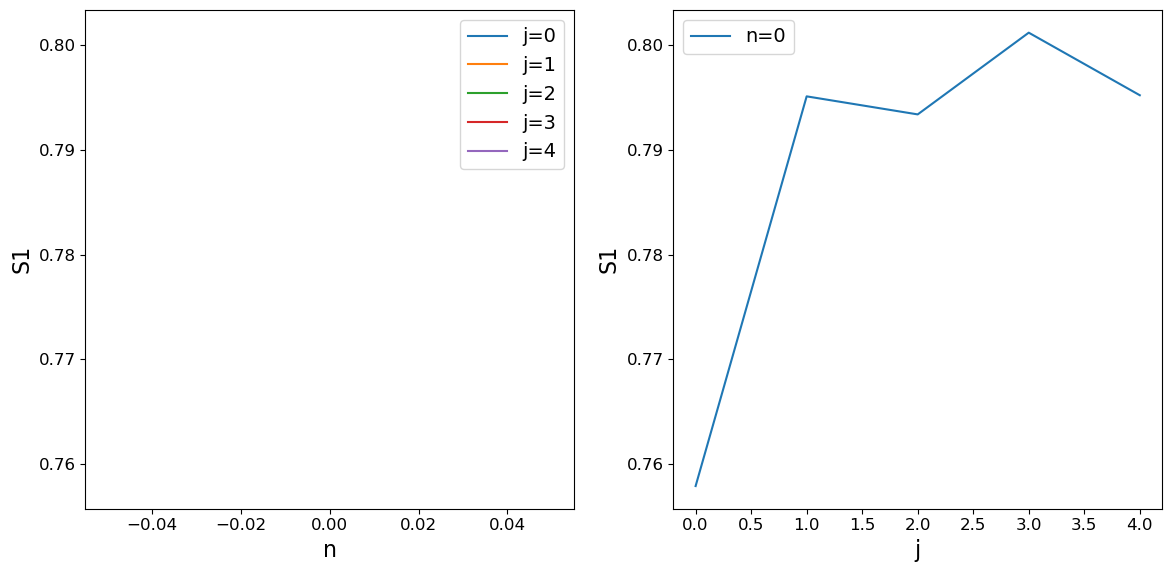

In [26]:
fig = plot_S1_P00(S1, ylabel='S1')

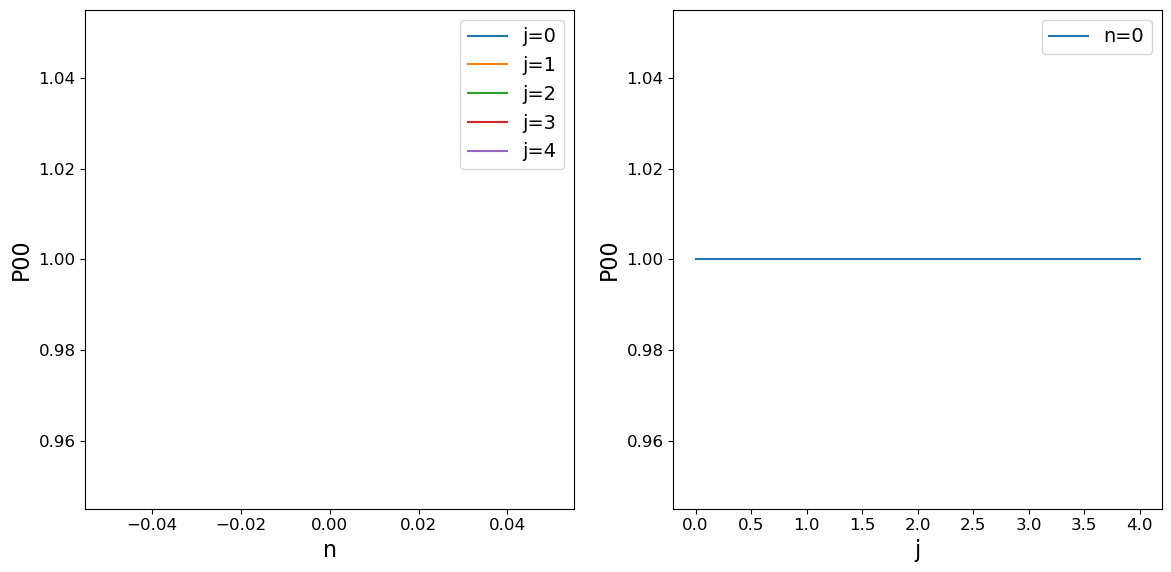

In [27]:
fig = plot_S1_P00(P00, ylabel='P00')

In [28]:
# Average over orientations
avgS1 = np.average(S1.reshape(-1, 2*N-1), axis=1)
avgP00 = np.average(P00.reshape(-1, 2*N-1), axis=1)


# Plot C01

In [29]:
print(len(C01))
print(C01)

4
[Array([[[-0.00145925]],

       [[-0.00109151]],

       [[ 0.00045574]],

       [[ 0.00077139]]], dtype=float64), Array([[[-0.00487589]],

       [[-0.00038859]],

       [[ 0.00074214]]], dtype=float64), Array([[[-0.00089273]],

       [[ 0.00163064]]], dtype=float64), Array([[[-0.003628]]], dtype=float64)]


In [30]:
jnp.min(jnp.abs(jnp.concatenate(C01)))

Array(0.00038859, dtype=float64)

In [31]:
color_list = [ 'c', 'b', 'r', 'g', 'orange', 'm']

2
[3 4 5 6]
(4, 1, 1)
3
[4 5 6]
(3, 1, 1)
4
[5 6]
(2, 1, 1)
5
[6]
(1, 1, 1)


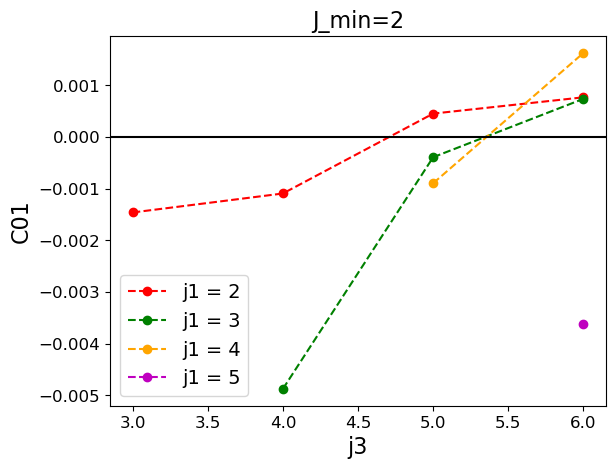

In [32]:
plt.figure()
for j1 in range(J_min, J_max):
    
    # Determine the j3 values j1 < j3
    print(j1)
    
    allj3 = np.arange(j1+1, J_max+1)
    print(allj3)
    for n3 in range(2*N-1):
        for n1 in range(1):
            plt.plot(allj3 , C01[j1-J_min][:, n3, n1], 'o--', color=color_list[j1], label=f'j1 = {j1}')
    print(C01[j1-J_min].shape)
plt.xlabel('j3')
plt.ylabel('C01')
plt.axhline(0, color='k')
plt.title(f'{J_min=}')
plt.legend()

# Check on white noise

We want to check that C01 is compatible with 0 for white noise.

In [58]:
nreals = 30  # Number of noise realisations

S1_all, P00_all, C01_all, C11_all = [], [], [], []
for i in range(nreals):
    print('real:', i)
    # Make a random complex map I
    reality=False
    I = np.random.randn(L, 2*L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
    
    # Spherical harmonc transform to get Ilm
    Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)
    
    # Compute the coefficients
    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters, for_synthesis=True)

    S1_all.append(S1)
    P00_all.append(P00)
    C01_all.append(C01)
    C11_all.append(C11)

# Make arrays instead of lists
S1_all = np.array(S1_all)
P00_all = np.array(P00_all)
C01_all = np.array(C01_all)
C11_all = np.array(C11_all)

real: 0

 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=64
real: 1
real: 2
real: 3
real: 4
real: 5
real: 6
real: 7
real: 8
real: 9
real: 10
real: 11
real: 12
real: 13
real: 14
real: 15
real: 16
real: 17
real: 18
real: 19
real: 20
real: 21
real: 22
real: 23
real: 24
real: 25
real: 26
real: 27
real: 28
real: 29


In [59]:
# Normalize by the STD over realisations
stdS1 = np.std(S1_all, axis=0)
stdP00 = np.std(P00_all, axis=0)
stdC01 = np.std(C01_all, axis=0)
stdC11 = np.std(C11_all, axis=0)

avgS1 = np.mean(S1_all, axis=0)
avgP00 = np.mean(P00_all, axis=0)
avgC01 = np.mean(C01_all, axis=0)
avgC11 = np.mean(C11_all, axis=0)

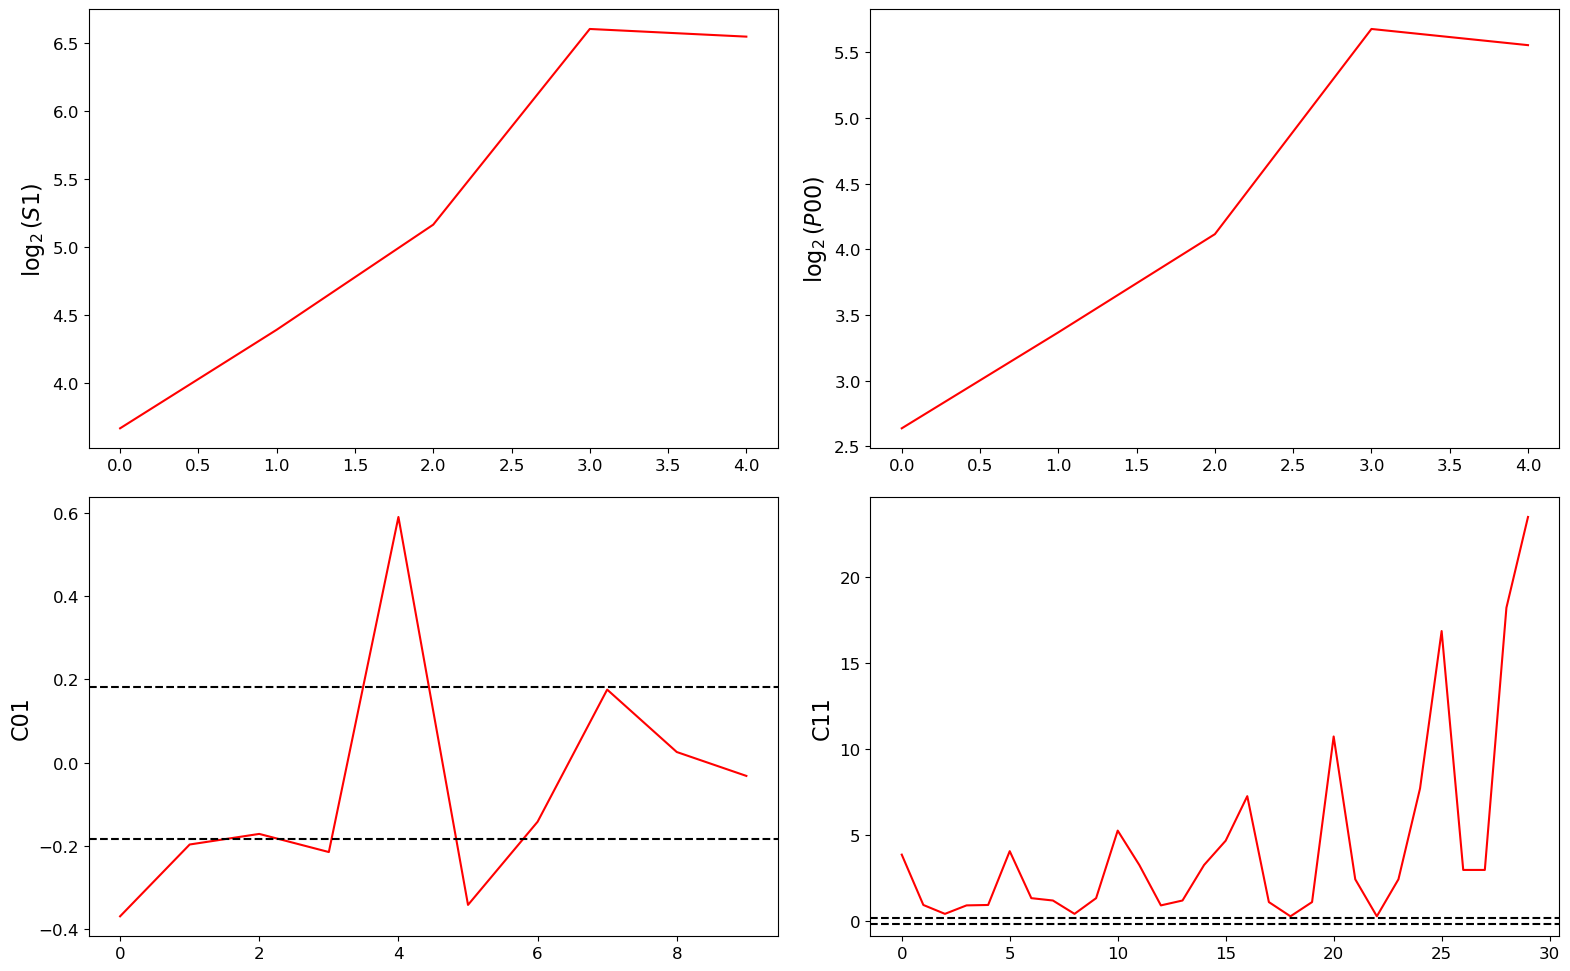

In [60]:
def forplot(ax):
    # ax.legend(fontsize=16)
    ax.axhline(-1/np.sqrt(nreals), color='k', ls='--')
    ax.axhline(1/np.sqrt(nreals), color='k', ls='--')
    return

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(np.log2(avgS1 / stdS1), 'r')
axs[0].set_ylabel(r'$\log_2(S1)$', fontsize=16)
#forplot(axs[0])

axs[1].plot(np.log2(avgP00 / stdP00), 'r')
axs[1].set_ylabel(r'$\log_2(P00)$', fontsize=16)
#forplot(axs[1])

axs[2].plot(avgC01/stdC01, 'r')
axs[2].set_ylabel('C01', fontsize=16)
forplot(axs[2])
# axs[2].set_yscale('log')

axs[3].plot(avgC11/stdC11, 'r')
axs[3].set_ylabel('C11', fontsize=16)
forplot(axs[3])
# axs[3].set_yscale('log')

fig.tight_layout()